# Synthetic Data - CS3110 Final Project

### Main Goal
Our team consists of Teddy Ruth, Joe Brennan, and Jordan Gottlieb. Our goal in this project is to go further in depth into the accuracies (or lackthereof) of synthetic data. How does accuracy compare across different marginals? What techniques can we use to maximize accuracy? What are some of the negative consequences of increasing accuracy?

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

evs = pd.read_csv("Electric_Vehicle_Population_Data.csv")

### dp_marginal

The below function calculates the marginal of a given column and epsilon value. The function returns a dictionary where the keys are the column value, and the value is the chance of occurence over the whole dataset. For example, when passing in the `County` column, the function will return the counties in the dataset as key values, and the number of occurences over the whole dataset

In [8]:
def dp_marginal(col, epsilon):
    
    data = evs[col].value_counts()
    results = [x for x in data]
    noisy = [laplace_mech(v, 1, epsilon) for v in results]
    labels = evs[col].value_counts().index.to_list()
    syn_rep = {}
    
    for x in range(len(labels)):
        syn_rep[labels[x]] = max(0, noisy[x])
    
    total = sum(syn_rep.values())
    
    marginal = {}
    for x in labels:
        marginal[x] = syn_rep[x] / total
    return marginal


marginal = dp_marginal('County', 1.0)

{'King': 0.5229930382828145, 'Snohomish': 0.11626837699808412, 'Pierce': 0.07722466003064696, 'Clark': 0.058746393828688494, 'Thurston': 0.03579093574377825, 'Kitsap': 0.032704101405575066, 'Spokane': 0.025182810098065597, 'Whatcom': 0.02423765105741954, 'Benton': 0.01217850479020027, 'Skagit': 0.011029052442476622, 'Island': 0.010788570572589083, 'Clallam': 0.0060418968260496884, 'Chelan': 0.00580000129195446, 'Jefferson': 0.005692062705463431, 'Yakima': 0.005521135747853763, 'San Juan': 0.005498581753282191, 'Cowlitz': 0.004959499607281825, 'Mason': 0.0046629034538253015, 'Lewis': 0.004084932889509764, 'Grays Harbor': 0.003530713706404713, 'Kittitas': 0.003448982248051361, 'Franklin': 0.0033263237373773735, 'Grant': 0.003121530311809876, 'Walla Walla': 0.0024571521663036134, 'Douglas': 0.002041313208838782, 'Whitman': 0.001808352579281018, 'Klickitat': 0.001602300813620116, 'Okanogan': 0.0014150251083727815, 'Stevens': 0.001308124872672427, 'Pacific': 0.0011982281346183188, 'Skamania

### dp_synthetic_data

This function generates synthetic data by generating a marginal for every column passed to the function and then combining data into a single dataframe to return. The function takes which columns, the number of rows to generate, and the epsilon value.

In [14]:
def dp_synthetic_data(cols, n, epsilon):
    df_data = {}
    for col in cols:
        df_data[col] = []
        data = evs[col].value_counts().index.to_list()
        results = [x for x in data]
        marginal = list(dp_marginal(col, epsilon).values())
        synthetic = np.random.choice(results, size=n, p=marginal)
        
        for x in synthetic:
            df_data[col].append(x)
            
    dp_df = pd.DataFrame.from_dict(df_data)
    
    return dp_df

dp_synthetic_data(['County', 'Model'], 100, 1.0)

,County,Model
0,Pierce,MODEL 3
1,King,PACIFICA
2,King,PACIFICA
3,Thurston,MODEL 3
4,Benton,EDV
...,...,...
95,Island,KONA ELECTRIC
96,Kitsap,NIRO
97,King,MUSTANG MACH-E
98,King,SOUL


The issue with `dp_synthetic_data` is that it does not preserve any of the trends in the dataset. It is merely taking 2 marginals and stitching them together. While this may generate good data if there is no preference to maintain trends in the data, this will not do a good job if it is desired to preserve the trends. In order to address this we can generate a new set of synthetic data using 2 way marginals.

In [15]:
def dp_two_marginal(col1, col2, epsilon):
    hist = evs[[col1, col2]].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    dp_hist = dp_hist.clip(lower=0)
    
    s = dp_hist.sum()
    
    dp_hist = dp_hist.to_frame().reset_index()
    dp_hist.rename(columns={0:'probability'}, inplace=True)
    
    for x in range(len(dp_hist)):
        val = dp_hist.at[x,'probability']
        dp_hist.at[x, 'probability'] = val / s
    
    
    return(dp_hist)

dp_two_marginal('County', 'Make', 1.0)

,County,Make,probability
0,King,TESLA,0.258334
1,Snohomish,TESLA,0.061094
2,King,NISSAN,0.041897
3,Pierce,TESLA,0.032549
4,King,CHEVROLET,0.032436
...,...,...,...
1183,Meade,VOLKSWAGEN,0.000000
1184,Mercer,CHEVROLET,0.000012
1185,Miami-Dade,TESLA,0.000004
1186,Middlesex,CHEVROLET,0.000009


While we may not initially notice anything by constructing a 2 way marginal, what happens when we construct a 4 way marginal?

In [16]:
def dp_four_marginal(col1, col2, col3, col4, epsilon):
    hist = evs[[col1, col2, col3, col4]].value_counts()
    dp_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    dp_hist = dp_hist.clip(lower=0)
    
    s = dp_hist.sum()
    
    dp_hist = dp_hist.to_frame().reset_index()
    dp_hist.rename(columns={0:'probability'}, inplace=True)
    
    for x in range(len(dp_hist)):
        val = dp_hist.at[x,'probability']
        dp_hist.at[x, 'probability'] = val / s
    
    
    return(dp_hist)

dp_four_marginal('County', 'Make', 'Electric Range', '2020 Census Tract', 1.0)

,County,Make,Electric Range,2020 Census Tract,probability
0,King,JEEP,21,5.303303e+10,0.003655
1,King,TESLA,0,5.303303e+10,0.003227
2,King,CHRYSLER,32,5.303303e+10,0.002258
3,King,CHRYSLER,32,5.303303e+10,0.002073
4,King,TESLA,0,5.303303e+10,0.001890
...,...,...,...,...,...
58234,King,NISSAN,215,5.303300e+10,0.000009
58235,King,NISSAN,215,5.303300e+10,0.000009
58236,King,NISSAN,215,5.303300e+10,0.000010
58237,King,NISSAN,215,5.303300e+10,0.000000


<Axes: xlabel='Make'>

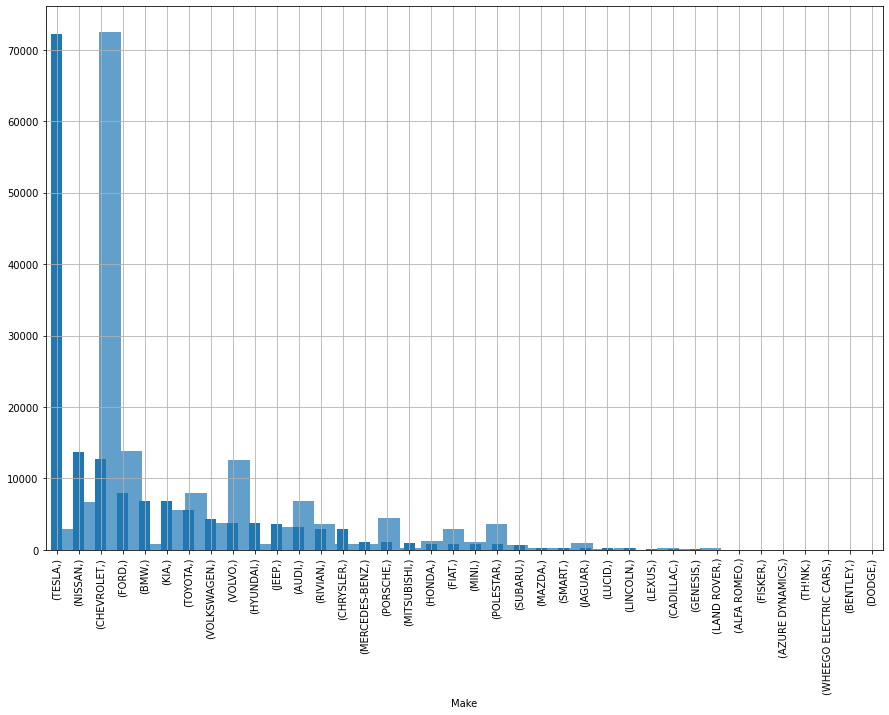

In [37]:
marginal = dp_marginal('Make', 1.0)

def gen_samples(cols, n, epsilon):
    df_data = {}
    for col in cols:
        df_data[col] = []
        data = evs[col].value_counts().index.to_list()
        results = [x for x in data]
        marginal = list(dp_marginal(col, epsilon).values())
        synthetic = np.random.choice(results, size=n, p=marginal)
        
        for x in synthetic:
            df_data[col].append(x)
            
    dp_df = pd.DataFrame.from_dict(df_data)

    return dp_df
syn_data = gen_samples(['Make'], len(evs), 1.0).value_counts()
syn_data.plot(figsize=(15,10), kind="bar")
evs['Make'].hist(alpha=0.7, bins = len(evs['Make'].unique()))


In [31]:
print(evs['Make'].value_counts())

TESLA                   72445
NISSAN                  13795
CHEVROLET               12568
FORD                     8009
BMW                      6842
KIA                      6754
TOYOTA                   5535
VOLKSWAGEN               4424
VOLVO                    3746
JEEP                     3690
HYUNDAI                  3671
AUDI                     3246
RIVIAN                   2934
CHRYSLER                 2859
MERCEDES-BENZ            1189
PORSCHE                  1065
MITSUBISHI                911
HONDA                     833
MINI                      821
POLESTAR                  804
FIAT                      795
SUBARU                    690
SMART                     276
MAZDA                     269
LINCOLN                   236
JAGUAR                    220
LUCID                     208
LEXUS                     201
CADILLAC                  197
GENESIS                   130
LAND ROVER                 48
ALFA ROMEO                 19
FISKER                     17
AZURE DYNA